In [1]:
## 导入必要的包
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage

# 一种储存数据的形式
import h5py

# 用于处理图片
from PIL import  Image

# 使用绘图工具时直接讲图绘制在notebook而不是新启一个Window
%matplotlib inline

In [2]:
## 定义数据导入方式
def load_dataset():
    train_dataset = h5py.File('/home/kelly/project/YIQIXUE_AI/data/week1/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 得到训练集的特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 得到训练集的Labels

    test_dataset = h5py.File('/home/kelly/project/YIQIXUE_AI/data/week1/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 得到测试集的特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 得到测试机的Labels

    classes = np.array(test_dataset["list_classes"][:]) # 得到分类的枚举值
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
## 读取训练数据（都是像素点）
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
## 简单查看数据分布
print "一共有{}个训练集和{}个测试集!".format(len(train_set_x_orig), len(test_set_x_orig))
print "训练集的形状是这样的{}".format(train_set_x_orig.shape)

一共有209个训练集和50个测试集!
训练集的形状是这样的(209, 64, 64, 3)


y = [0], it's a 'non-cat' picture.


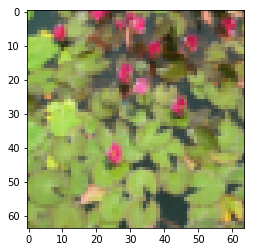

In [5]:
## 随便取出一个不是猫的像素点看看图片
index = 18
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


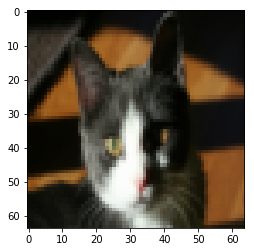

In [6]:
## 随便取出一个是猫的像素点看看图片
index = 19
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [7]:
## 分别取出训练集和测试并对整体数据进行一个观察
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("训练集的数量是: m_train = " + str(m_train))
print ("测试集的数量是: m_test = " + str(m_test))
print ("每一个图片的高和宽是: num_px = " + str(num_px))
print ("每一个图片的尺寸是: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练集的数量是: m_train = 209
测试集的数量是: m_test = 50
每一个图片的高和宽是: num_px = 64
每一个图片的尺寸是: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [8]:
## 将测试集和训练集的shape做转换，让其可以做训练，即flatten，其实就是num_px * num_px * 3（channel）
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [9]:
## 对像素做归一化处理,注意要是float格式
## 通常处理图片数据有三种常见操作
# 确定问题的维度、形状：多少个训练集、多少个测试集，像素是几乘几的
# 对数据集做处理，保证每一个样本数据是一个向量，向量的维度一定是(num_px * num_px * 3, 1)
# 对数据做归一化处理，即每个像素/255
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 接下来我们要手动实现下面几个公式 ##
对于单条数据： $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

然后计算损失函数：
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**遵循下面几个步骤搭建一个简单网络**:
1. 首先需要设计好模型的结构
2. 初始化所有模型的参数:
    - 可能全部用0初始化
    - 可能使用满足某种分布的初始化
3. 循环:
    - 计算当前的损失值（向前传播）
    - 计算当前的梯度（反向传播）
    - 更新参数（梯度下降）

In [10]:
## 定义Sigmoid函数
def sigmoid(z):
    """
    Sigmoid函数

    Arguments:
    x -- 一个实数或者任意长度的数组

    返回:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s

In [11]:
## 测试Sigmoid结果

print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(-9) = " + str(sigmoid(-9)))
print ("sigmoid(np.random.rand(6,6))" + str(sigmoid(np.random.rand(6,6))))

sigmoid(0) = 0.5
sigmoid(-9) = 0.000123394575986
sigmoid(np.random.rand(6,6))[[ 0.55970733  0.63902434  0.68173536  0.67834471  0.71431397  0.599367  ]
 [ 0.61120978  0.59123617  0.61046119  0.55296799  0.71313338  0.68280569]
 [ 0.62989959  0.54405302  0.59863805  0.52293598  0.69281012  0.63245594]
 [ 0.63773104  0.70199866  0.6969986   0.72522131  0.67566828  0.53703093]
 [ 0.65860417  0.70863424  0.60952504  0.63340431  0.64030294  0.66459437]
 [ 0.60092869  0.61266479  0.71552463  0.63100948  0.63538287  0.59422923]]


In [12]:
## 用0初始化参数

def initialize_with_zeros(dim):
    """
    该函数会返回一个shape为(dim,1),每一个元素都是0的向量作为w,并定义b为0
    
    Argument:
    dim -- 向量w的size(参数的个数)
    
    返回:
    w -- 初始化后shape为(dim, 1)的向量
    b -- 输出化后的实数(其实就是偏差)
    """
    
    w = np.zeros(shape=(dim, 1)) # 使用numpy生成所有元素为0的向量
    b = 0

    assert(w.shape == (dim, 1)) # 检查生成的向量w的shape是否和期望值一样
    assert(isinstance(b, float) or isinstance(b, int)) # 检查数据结构
    
    return w, b

In [13]:
## 测试初始化函数
dim = 6
w, b = initialize_with_zeros(dim)

print ("w = " + str(w))
print ("b = " + str(b))

w = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
b = 0


## 现在我们可以开始搭建神经网络 ##
#### 核心是通过"forward" 和 "backward"学习参数  ####

Forward Propagation:
- X 是我们的训练样本
- 我们需要计算: $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- 然后就可以计算损失函数: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

下面这个求导的公式我们后面也要用到: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [28]:
# 向前传播,一定要注意所有的数值都是float类型

def propagate(w, b, X, Y):
    """
    计算损失函数和梯度值

    Arguments:
    w -- weights, size = (num_px * num_px * 3, 1) 的数组
    b -- bias, 实数
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- 负的logistic回归的log似然损失值
    dw -- w的损失梯度,自然和w的shape是一样的,需要注意的是返回的值是一个字典。
    db -- b的损失梯度,自然和b的shape是一样的,需要注意的是返回的值是一个字典。
    
    """
    
    # 样本数,即上述公式的m
    m = X.shape[1]
    
    # 向前传播 (由 X 得到 COST)
    A = sigmoid(np.dot(w.T, X) + b) # 计算激活值,需要注意的是sigmoid激活的值是通过对输入进行线性变换后的值,np.dot就是向量点乘
    cost = (-1. / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)), axis=1) # 根据上述公式和A计算cost
    
    # 反向传播 (计算梯度)
    dw = (1.0 / m) * np.dot(X, (A - Y).T)
    db = (1.0 / m) * np.sum(A - Y)


    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    # 矩阵转向量
    cost = np.squeeze(cost)

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [29]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[ 0.99993216]
 [ 1.99980262]]
db = 0.499935230625
cost = 6.00006477319


### 接下来就要开始进入循环部分,来优化模型(参数) ###
- 从头开始,初始化所有参数
- 这样你可以计算模型的损失函数的它的梯度
- 现在，你需要用梯度下降来更新参数

**注意:**
你进行循环的目的就是通过最小化损失函 $J$ 数来不断更新 $w$ 和 $b$.

具体的更新原则我们只需要看 $ \theta = \theta - \alpha \text{ } d\theta$ 就够了,PS. $\alpha$ 是学习率.

In [30]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    通过梯度下降来优化w 和 b
    
    Arguments:
    w -- weights, size = (num_px * num_px * 3, 1) 的数组
    b -- bias, 实数
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    num_iterations -- 循环进行优化的次数
    learning_rate -- 学习率就是通过梯度下降更新参数的标准
    print_cost -- 每循环多少次打印出来损失函数
    
    Returns:
    params -- 包含 weights(w)和bias(b)的字典
    grads -- 损失函数对应的w和b的梯度
    costs -- 模型训练过程中产生的所有代价值,最后可用来绘制学习曲线。list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
         我们可以直接用上述已经定义好的函数
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w=w, b=b, X=X, Y=Y)

        
        # 梯度求导
        dw = grads["dw"]
        db = grads["db"]
        
        # 更新参数
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        
        # 将cost写入list
        if i % 100 == 0:
            costs.append(cost)
        
        # 没100次循环输出一次日志
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [31]:
## 测试一下
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[ 0.1124579 ]
 [ 0.23106775]]
b = 1.55930492484
dw = [[ 0.90158428]
 [ 1.76250842]]
db = 0.430462071679


### 预测 ###

通过之前函数的迭代,我们已经学到了最优的w和b,接下来就可以用这些参数来对输入数据做预测了，具体步骤如下：

1. 计算 $\hat{Y} = A = \sigma(w^T X + b)$

2. 最终是用LR做结果输出的，因此我们设定0.5为阈值，用 `if`/`else` 输出预测结果。

In [34]:
# 预测

def predict(w, b, X):
    '''
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    
    m = X.shape[1] # 得到要预测的样本数
    Y_prediction = np.zeros((1,m)) # 设定一个长度为m的向量
    w = w.reshape(X.shape[0], 1) # 重新设定w的shape
    
    # 使用输入值，用学到的参数直接计算得到输出值
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        
        # 用阈值划分分类结果
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
            
        else:
            Y_prediction[0, i] = 0
            
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [35]:
# 测试一下函数
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 1.  1.]]


## 组合函数，得到模型 ##

神经网络的整体结构正式由上述若干个函数构成的，所谓模型，就是讲这些函数结合在一起


In [36]:
# 生成模型

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- 包含cost,w,b,learning_rate,num_iterations,Y_prediction_test,Y_prediction_train的所有模型信息
    """
    
    # 用0初始化所有参数
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # 梯度下降
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # 更新参数
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [37]:
# 输入训练数据，得到一个分辨是否是猫的模型
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.043062201 %
test accuracy: 70.0 %


The test_set_y of index=2's  predicted result is [ 1.], it's a cat


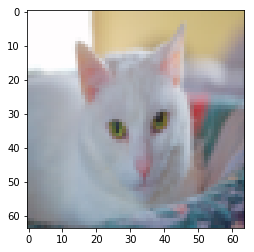

In [59]:
# 测试一下模型
index = 2
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print "The test_set_y of index=2's  predicted result is {}, it's a cat".format(d['Y_prediction_test'][:,index])

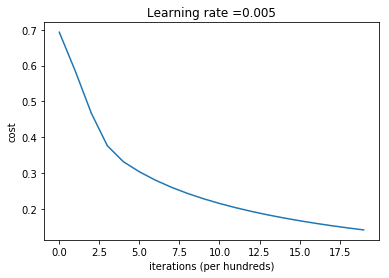

In [60]:
# 用收集到costs绘制学习曲线
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.5215311005 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.995215311 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.4210526316 %
test accuracy: 36.0 %

-------------------------------------------------------



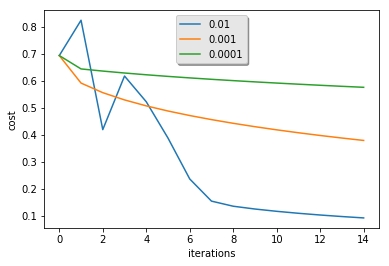

In [62]:
# 调整不同的learning_rate看看模型的表现(可以看做是一个调参过程)

learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 1.0, your algorithm predicts a "cat" picture.


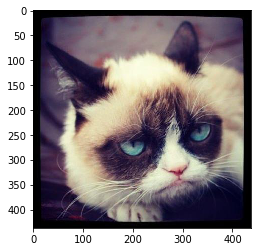

In [64]:
## 用你自己的图片对模型做个测试

fname = "/home/kelly/project/YIQIXUE_AI/data/week1/angry_cat.jpeg"   # 写你自己图片的路劲

# 刚才组建的模型测试

image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


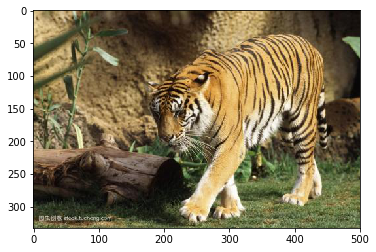

In [65]:
## 用你自己的图片对模型做个测试

fname = "/home/kelly/project/YIQIXUE_AI/data/week1/tiger.jpg"   # 写你自己图片的路劲

# 刚才组建的模型测试

image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")